In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder

import plotly.express as px

from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# data updates 
df['Churn'] = df['Churn'].map({'Yes':1,'No':0})


df['InternetType']=df['InternetService']
df['InternetService'] = df['InternetService'].map({'Fiber optic':'Yes','DSL':'Yes','No':'No'})

product_features = [
    'PhoneService', 'InternetService', 
    'OnlineBackup', 'OnlineSecurity', 
    'DeviceProtection', 'TechSupport', 
    'StreamingTV', 'StreamingMovies'
]

# for feature in product_features:
#     df[feature].replace({'Yes':1,'No':0},inplace=True)

In [3]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... TechSupport  \
0  No phone service             Yes             No  ...          No   
1                No             Yes            Yes  ...          No   
2                No             Yes            Yes  ...          No   
3  No phone service             Yes            Yes  ...         Yes   
4                No             Yes             No  ...          No   

  StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No              No  Month-to-month              Yes   
1          No              No        One year               No   
2          No              No  Month-to-month              Yes   
3          No              No        One year               No   
4          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges TotalCharges  Churn InternetType  
0           Electronic check          29.85        29.85      0          DSL  
1               Mailed check          56.95       1889.5      0          DSL  
2               Mailed check          53.85       108.15      1          DSL  
3  Bank transfer (automatic)          42.30      1840.75      0          DSL  
4           Electronic check          70.70       151.65      1  Fiber optic  

[5 rows x 22 columns]

### Customer Lifetime Value

We can only look at CLTV for those who have already churned. 

Here is the formula for Customer Lifetime Value:

![CLV formula](images/CLV_formula.png)

ARPA equals the average revenue per account for a period of time (e.g. monthly)

In [4]:
churned = df[df['Churn']==1].copy()
churned['TotalCharges'] = churned['TotalCharges'].astype(float)

In [5]:
simple_churnRate = churned.shape[0]/df.shape[0]
simple_churnRate

0.2653698707936959

In [6]:
churned['simple_clv'] = churned.apply(lambda x: (1/simple_churnRate)*x['MonthlyCharges'],axis=1)

In [7]:
churned[['MonthlyCharges','TotalCharges','simple_clv']]

MonthlyCharges  TotalCharges  simple_clv
2              53.85        108.15  202.924318
4              70.70        151.65  266.420599
5              99.65        820.50  375.513617
8             104.80       3046.05  394.920492
13            103.70       5036.30  390.775334
...              ...           ...         ...
7021           59.80        727.80  225.345853
7026           44.20        403.35  166.559979
7032           75.75         75.75  285.450642
7034          102.95       6886.25  387.949090
7041           74.40        306.60  280.363403

[1869 rows x 3 columns]

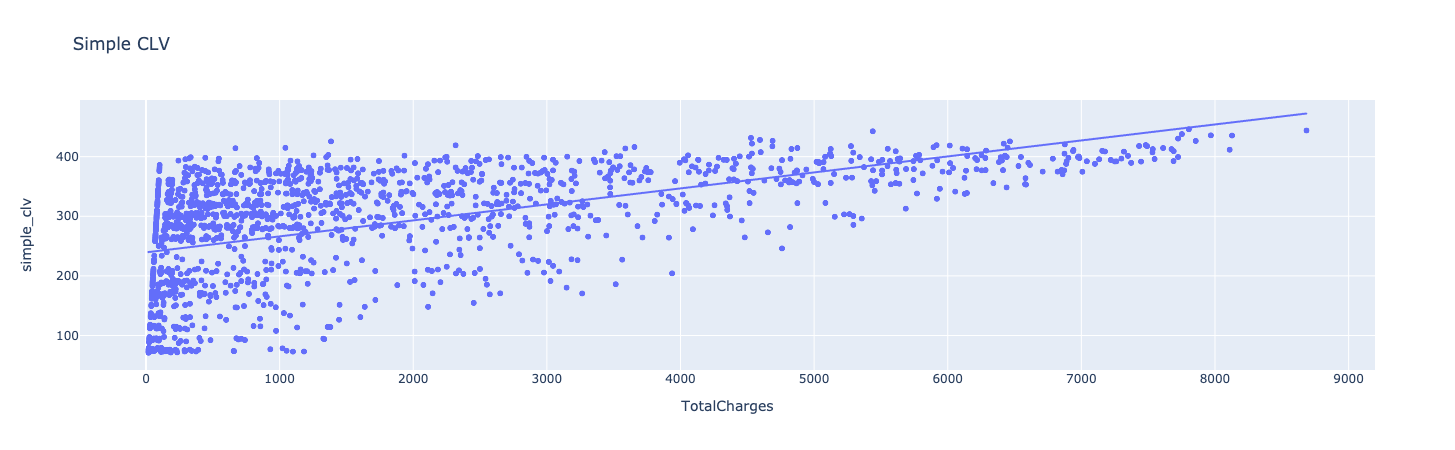

In [8]:
fig = px.scatter(data_frame=churned,x='TotalCharges',y='simple_clv',title='Simple CLV',trendline='ols')
fig

In [9]:
r2_score(churned['TotalCharges'],churned['simple_clv'])

-0.38692288658749496

These results are...not great. Let's see if grouping customers by contract length helps.

In [10]:
churnRates_byContractType = {}
for contract in df['Contract'].unique():
    churnRates_byContractType[contract] = churned[churned['Contract']==contract].shape[0] / df[df['Contract']==contract].shape[0]
churnRates_byContractType

{'Month-to-month': 0.4270967741935484,
 'One year': 0.11269517990495587,
 'Two year': 0.02831858407079646}

In [11]:
churned['clv_by_ContractType']=churned.apply(
    lambda x: (1/churnRates_byContractType[x['Contract']])*x['MonthlyCharges'],axis=1
)

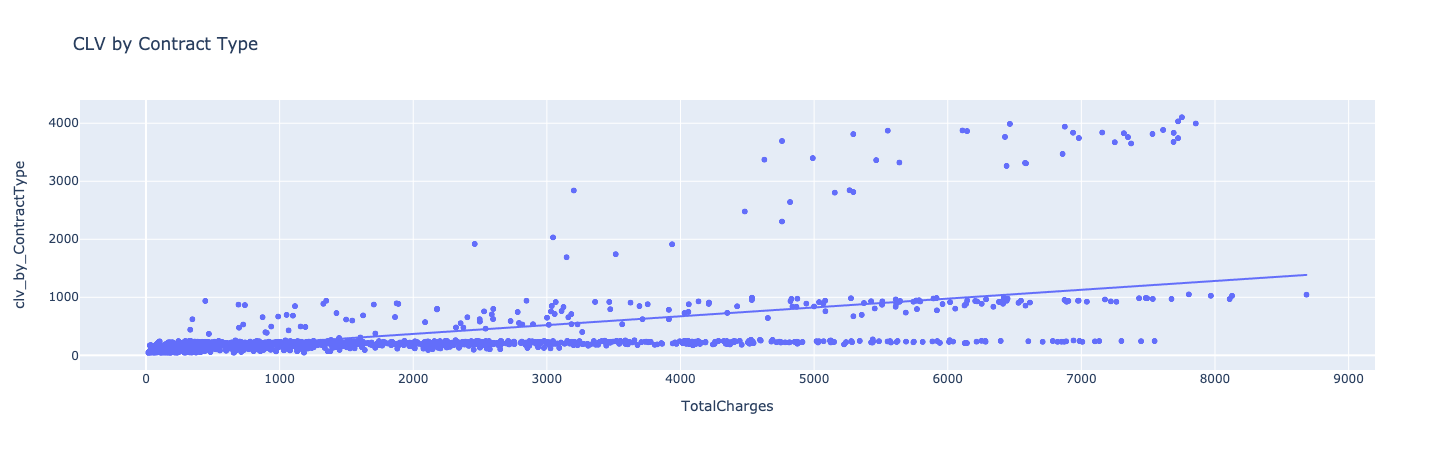

In [12]:
fig = px.scatter(data_frame=churned,x='TotalCharges',y='clv_by_ContractType',title='CLV by Contract Type',trendline='ols')
fig

In [13]:
r2_score(churned['TotalCharges'],churned['clv_by_ContractType'])

-0.19584579912803535

### Decision Tree

In [766]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.tree import export_graphviz
from IPython.display import Image  
from pydotplus import graph_from_dot_data

df_dt = df.copy()

df_dt['Phone Lines'] = df_dt['MultipleLines'].map({'No phone service':0,'No':1,'Yes':2})
df_dt.drop(columns=['MultipleLines'],inplace=True)

cat_features = ['Contract','PaymentMethod']

for feature in cat_features:
    df_dt = df_dt.merge(pd.get_dummies(df_dt[feature],drop_first=True),right_index=True,left_index=True)
    df_dt.drop(columns=[feature],inplace=True)
df_dt.replace({'Yes':1,'No':0},inplace=True)

df_dt['male'] = df_dt['gender'].map({'Male':1,'Female':0})
df_dt.drop(columns=['gender'],inplace=True)

df_dt.replace({'No internet service':0},inplace=True)

df_dt = df_dt.join(pd.get_dummies(df_dt['InternetType']).drop(columns=[0]))
df_dt = df_dt.drop(columns='InternetType')
df_dt.head()

customerID  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0  7590-VHVEG              0        1           0       1             0   
1  5575-GNVDE              0        0           0      34             1   
2  3668-QPYBK              0        0           0       2             1   
3  7795-CFOCW              0        0           0      45             0   
4  9237-HQITU              0        0           0       2             1   

   InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
0                1               0             1                 0  ...   
1                1               1             0                 1  ...   
2                1               1             1                 0  ...   
3                1               1             0                 1  ...   
4                1               0             0                 0  ...   

   Churn  Phone Lines  One year  Two year  Credit card (automatic)  \
0      0            0         0         0                        0   
1      0            1         1         0                        0   
2      1            1         0         0                        0   
3      0            0         1         0                        0   
4      1            1         0         0                        0   

  Electronic check  Mailed check  male  DSL  Fiber optic  
0                1             0     0    1            0  
1                0             1     1    1            0  
2                0             1     1    1            0  
3                0             0     1    1            0  
4                1             0     0    0            1  

[5 rows x 26 columns]

In [871]:
X = df_dt.drop(columns=['customerID','TotalCharges','tenure','Churn'])
Y = df_dt['Churn']

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=.2,stratify=df[['Contract','Churn']])

In [888]:
churn_tree = DecisionTreeClassifier(min_samples_leaf=.05)

In [889]:
fit = churn_tree.fit(X_train,y_train)

In [890]:
pred = fit.predict(X_test)

In [891]:
pd.DataFrame(classification_report(y_test,pred,output_dict=True))

0           1  accuracy    macro avg  weighted avg
precision     0.807595    0.651786  0.782825     0.729690      0.766237
recall        0.924638    0.390374  0.782825     0.657506      0.782825
f1-score      0.862162    0.488294  0.782825     0.675228      0.762924
support    1035.000000  374.000000  0.782825  1409.000000   1409.000000

In [892]:
def plot_tree(estimator):    
    # Create DOT data
    dot_data = export_graphviz(estimator, out_file=None, 
                               feature_names=X_train.columns,  
                               class_names=np.unique(y_train).astype('str'), 
                               filled=True, rounded=True, special_characters=True)

    # Draw graph
    graph = graph_from_dot_data(dot_data)  

    # Show graph
    return Image(graph.create_png())

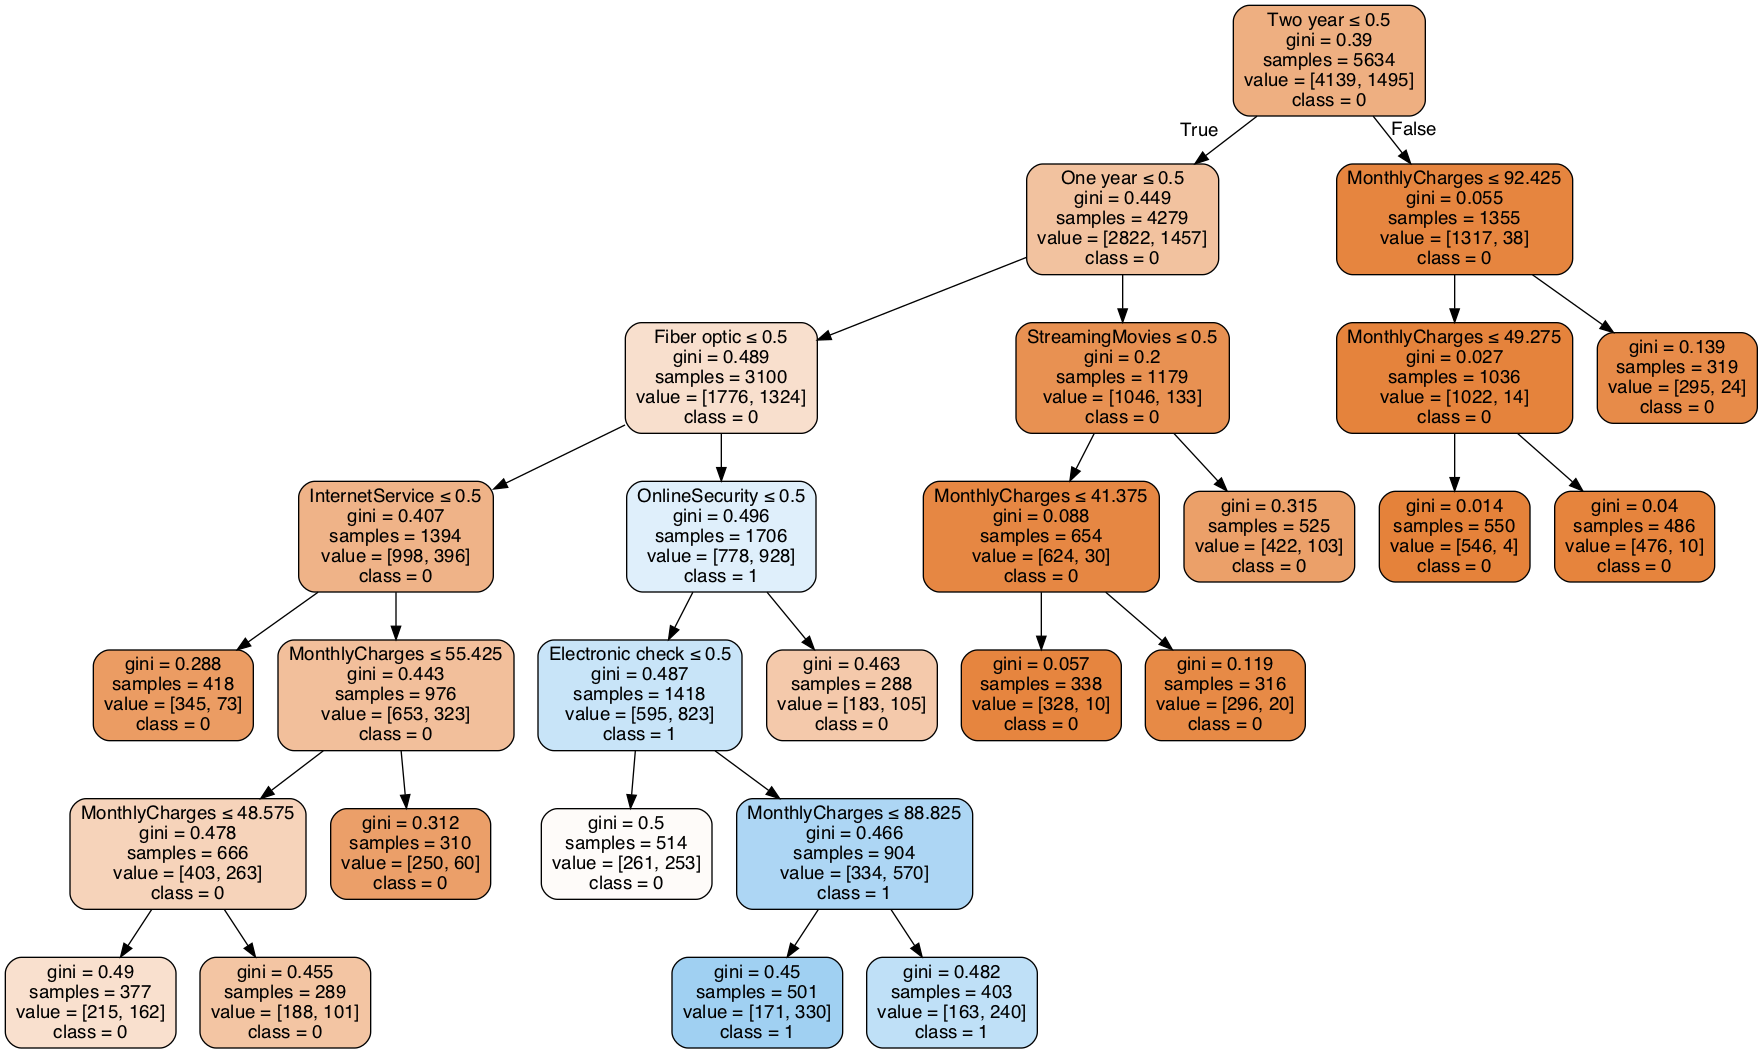

In [893]:
plot_tree(churn_tree)

In [894]:
test_data = X_test.copy()
test_data['leaf']=churn_tree.apply(test_data)

In [895]:
i = X_test.index
test_data = test_data.join(df_dt.loc[i][['TotalCharges','Churn']])
test_data.replace(' ',np.nan,inplace=True)
test_data['TotalCharges']=test_data['TotalCharges'].astype(float)

In [896]:
actual_clv = test_data[test_data['Churn']==1].groupby('leaf')[['TotalCharges']].mean()

In [900]:
predicted_clv = test_data.groupby('leaf')[['MonthlyCharges','Churn']].mean()

In [901]:
1/predicted_clv['Churn']*predicted_clv['MonthlyCharges']

leaf
4       82.623077
7       95.816667
8      221.405556
9      373.554545
12     179.153226
14     116.421591
15     154.545690
16     231.332692
19     933.925000
20     861.075000
21     487.884000
24    1798.500000
25    8493.750000
26    1110.535714
dtype: float64

In [899]:
actual_clv

TotalCharges
leaf              
4        78.723077
7       191.183333
8       438.144444
9       679.009091
12     1647.041935
14      649.312500
15     1879.821552
16     2013.853846
19      816.400000
20     2980.691667
21     4784.206000
24     1943.900000
25     4759.750000
26     7007.835714

### Using Decision Tree probabilites as features in a linear regression 

Not sure if this makes sense yet. 

In [691]:

class ChurnProbabilityTransformer(BaseEstimator,TransformerMixin):
    def __init__(self,**params):
        
        #self.reg = DecisionTreeRegressor(**reg_params)
        for k,v in params.items():
            setattr(self,k,v)
        
        self.clf = DecisionTreeClassifier(**params)
    def fit(self,X,y=None):
        
        self.clf.fit(
            X.drop(columns=['Churn']),X['Churn']
        )
        
#         self.reg.fit(
#             X.drop(columns=['MonthlyCharges','Churn']),X['MonthlyCharges']
#         )
        
        return self
    
    def transform(self,X):
        churn_prob = self.clf.predict_proba(X.drop(columns=['Churn']))[:,1]
        #predicted_rate = self.reg.predict(X.drop(columns=['MonthlyCharges','Churn']))
        
        out = X.copy()
        out['churn_probability']=churn_prob
        return out
    
class MonthlyRatePrediction(BaseEstimator,TransformerMixin):
    def __init__(self,**params):
        
        for k,v in params.items():
            setattr(self,k,v)
        self.reg = DecisionTreeRegressor(**params)
    
    def fit(self,X,y=None):
        
        self.reg.fit(
            X.drop(columns=['MonthlyCharges','Churn']),X['MonthlyCharges']
        )
        
        return self
    
    def transform(self,X):
        predicted_rate = self.reg.predict(X.drop(columns=['MonthlyCharges','Churn']))
        
        out = X.copy()
        out['predicted_rate']=predicted_rate

        return out

In [692]:
churn = ChurnProbabilityTransformer(min_samples_split=.1)
rate = MonthlyRatePrediction(min_samples_split=.1)

In [693]:
pipe = Pipeline([
    ('clv_transformer',churn),
    ('rate',rate)
])

In [702]:
X = df_dt.drop(columns=['customerID','TotalCharges','tenure'])
Y = df_dt['TotalCharges']

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=.2,stratify=df[['Contract','Churn']])

In [709]:
train = pipe.fit_transform(X_train)

In [715]:
train = train[train['Churn']==1]

In [718]:
y_train.loc[train.index]

5186      36.45
1294     270.95
5299     2812.2
2642    4045.65
1832    2572.95
         ...   
6473       94.4
6537    7968.85
272        24.8
6066      178.1
4323    2781.85
Name: TotalCharges, Length: 1495, dtype: object

In [721]:
lin_reg.fit(train,y_train.loc[train.index])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [722]:
test = pipe.transform(X_test)
test

SeniorCitizen  Partner  Dependents  PhoneService  InternetService  \
5488              1        1           0             1                1   
608               0        1           1             1                1   
2971              0        1           1             1                1   
5254              0        1           1             1                1   
1593              0        1           1             1                0   
...             ...      ...         ...           ...              ...   
6737              0        1           0             1                1   
468               0        0           1             1                0   
3672              0        1           0             1                1   
3255              1        1           1             1                1   
5105              1        1           0             1                1   

      OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  \
5488               0             1                 1            1   
608                1             1                 1            1   
2971               1             1                 1            1   
5254               1             1                 1            1   
1593               0             0                 0            0   
...              ...           ...               ...          ...   
6737               0             1                 1            1   
468                0             0                 0            0   
3672               0             0                 0            0   
3255               1             1                 0            1   
5105               0             1                 0            1   

      StreamingTV  ...  One year  Two year  Credit card (automatic)  \
5488            1  ...         1         0                        0   
608             1  ...         0         1                        0   
2971            1  ...         0         1                        1   
5254            1  ...         0         1                        1   
1593            0  ...         0         0                        0   
...           ...  ...       ...       ...                      ...   
6737            1  ...         0         1                        0   
468             0  ...         0         1                        0   
3672            1  ...         1         0                        1   
3255            1  ...         1         0                        1   
5105            1  ...         1         0                        1   

      Electronic check  Mailed check  male  DSL  Fiber optic  \
5488                 0             0     1    0            1   
608                  0             0     1    0            1   
2971                 0             0     0    1            0   
5254                 0             0     1    0            1   
1593                 0             1     1    0            0   
...                ...           ...   ...  ...          ...   
6737                 0             0     0    0            1   
468                  0             1     0    0            0   
3672                 0             0     0    1            0   
3255                 0             0     0    0            1   
5105                 0             0     0    0            1   

      churn_probability  predicted_rate  
5488           0.199531       88.935653  
608            0.063584      107.903169  
2971           0.000000       76.174417  
5254           0.063584      107.903169  
1593           0.151786       19.984278  
...                 ...             ...  
6737           0.063584      107.903169  
468            0.005618       19.984278  
3672           0.136150       76.174417  
3255           0.199531      107.903169  
5105           0.199531      107.903169  

[1409 rows x 25 columns]

In [754]:
predicted_clv = lin_reg.predict(test)

In [761]:
results = pd.DataFrame([predicted_clv,y_test]).T

In [762]:
results = results.replace(' ',np.nan)

In [763]:
results.dropna(inplace=True)

In [764]:
r2_score(results[1],results[0])

0.6719540853319494

In [354]:
clf = DecisionTreeClassifier(min_samples_leaf=.10)

In [360]:
clf_fit = clf.fit(X_train,y_train['Churn'])

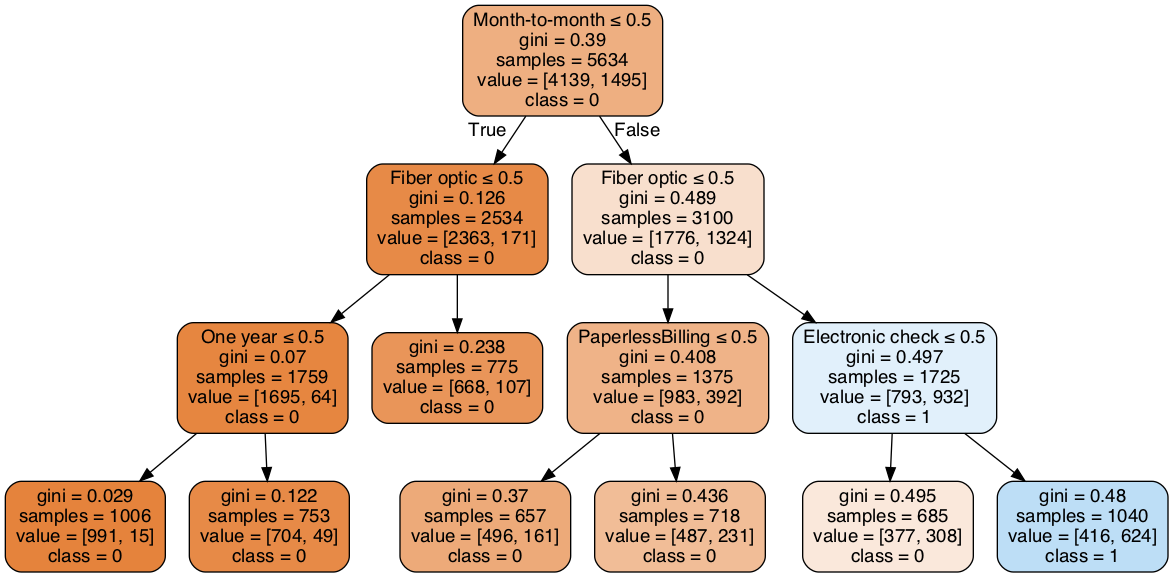

In [366]:
plot_tree(clf,'Churn')

In [318]:
reg = DecisionTreeRegressor(min_samples_leaf=.1)

In [367]:
reg_fit = reg.fit(X_train,y_train['MonthlyCharges'])

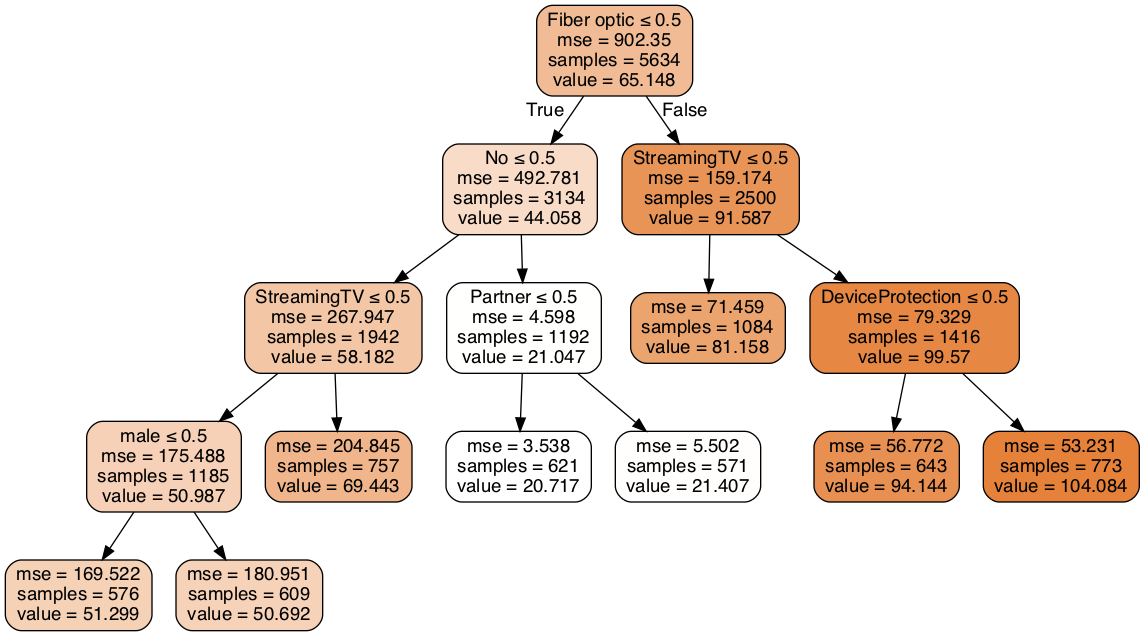

In [368]:
plot_tree(reg,'MonthlyCharges')

In [370]:
churn_prob = clf_fit.predict_proba(X_train)[:,1]

monthlyRate_prediction = reg_fit.predict(X_train)

X_train['churn_prob']=churn_prob

X_train['monthlyRate_prediction']=monthlyRate_prediction

In [380]:
X_train

SeniorCitizen  Partner  Dependents  PhoneService  InternetService  \
1144              0        0           0             0                1   
4919              0        1           0             0                1   
830               0        1           0             1                1   
1916              0        0           0             1                1   
6910              0        0           1             1                1   
...             ...      ...         ...           ...              ...   
1471              0        1           0             1                1   
5722              1        1           0             1                1   
4775              0        1           0             1                1   
6760              0        0           1             1                1   
2119              0        1           1             1                0   

      OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  \
1144               0             0                 0            0   
4919               1             0                 1            1   
830                1             1                 0            1   
1916               0             1                 1            0   
6910               1             1                 1            1   
...              ...           ...               ...          ...   
1471               0             0                 1            0   
5722               1             0                 0            1   
4775               0             1                 1            0   
6760               1             0                 0            0   
2119               0             0                 0            0   

      StreamingTV  ...  DSL  Fiber optic  No  Bank transfer (automatic)  \
1144            0  ...    1            0   0                          0   
4919            0  ...    1            0   0                          0   
830             1  ...    0            1   0                          0   
1916            0  ...    0            1   0                          1   
6910            1  ...    0            1   0                          0   
...           ...  ...  ...          ...  ..                        ...   
1471            1  ...    0            1   0                          0   
5722            1  ...    0            1   0                          1   
4775            1  ...    0            1   0                          0   
6760            0  ...    1            0   0                          0   
2119            0  ...    0            0   1                          1   

      Credit card (automatic)  Electronic check  Mailed check  male  \
1144                        0                 1             0     1   
4919                        1                 0             0     1   
830                         0                 1             0     0   
1916                        0                 0             0     0   
6910                        0                 1             0     1   
...                       ...               ...           ...   ...   
1471                        1                 0             0     1   
5722                        0                 0             0     0   
4775                        1                 0             0     0   
6760                        0                 1             0     1   
2119                        0                 0             0     1   

      churn_prob  monthlyRate_prediction  
1144    0.321727               50.692447  
4919    0.014911               50.692447  
830     0.138065               94.144246  
1916    0.449635               81.158164  
6910    0.138065              104.083765  
...          ...                     ...  
1471    0.449635              104.083765  
5722    0.449635               94.144246  
4775    0.449635              104.083765  
6760    0.321727               50.692447  
2119    0.065073               21.406655  

[5634

In [382]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

In [388]:
i = y_train[y_train['Churn']==1].index

In [403]:
lin_fit = lin_reg.fit(X_train.loc[i],y_train.loc[i]['TotalCharges'])

In [404]:
churn_prob = clf_fit.predict_proba(X_test)[:,1]

monthlyRate_prediction = reg_fit.predict(X_test)

X_test['churn_prob']=churn_prob

X_test['monthlyRate_prediction']=monthlyRate_prediction

ValueError: Number of features of the model must match the input. Model n_features is 24 and input n_features is 26 

In [405]:
pred = lin_fit.predict(X_test)

In [408]:
X_test['predictions']=pred

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [410]:
predicted = X_test.copy()

In [411]:
predicted['TotalCharges']=y_test['TotalCharges']

In [413]:
predicted['Churn']=y_test['Churn']

In [419]:
test = predicted[predicted['Churn']==1]

In [421]:
from sklearn.base import BaseEstimator, TransformerMixin

In [578]:
X = df_dt.drop(columns=['customerID','tenure'])
Y = df_dt['TotalCharges']

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=.2,stratify=df[['Contract','Churn']])



In [582]:
tfm = TreeTransformer(clf_params={'min_samples_leaf':.1})

In [566]:
data_prepared=tfm.fit_transform(X_train)
data_prepared

SeniorCitizen  Partner  Dependents  PhoneService  InternetService  \
1944              0        0           1             0                1   
3772              0        1           0             1                1   
6360              0        0           0             1                0   
3495              1        0           0             1                1   
2140              0        1           1             1                1   
...             ...      ...         ...           ...              ...   
1308              1        0           0             1                1   
6986              0        1           0             1                1   
1478              0        0           0             1                1   
4349              1        1           0             1                1   
6169              0        0           0             1                1   

      OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  \
1944               0             0                 0            0   
3772               1             0                 0            0   
6360               0             0                 0            0   
3495               0             0                 0            0   
2140               0             0                 0            0   
...              ...           ...               ...          ...   
1308               0             0                 0            0   
6986               0             1                 0            1   
1478               0             1                 1            0   
4349               1             0                 0            0   
6169               0             0                 0            0   

      StreamingTV  ...  DSL  Fiber optic  No Bank transfer (automatic)  \
1944            0  ...    1            0   0                         0   
3772            1  ...    0            1   0                         0   
6360            0  ...    0            0   1                         0   
3495            0  ...    0            1   0                         0   
2140            0  ...    0            1   0                         0   
...           ...  ...  ...          ...  ..                       ...   
1308            1  ...    0            1   0                         0   
6986            1  ...    0            1   0                         0   
1478            1  ...    0            1   0                         0   
4349            0  ...    0            1   0                         0   
6169            0  ...    1            0   0                         1   

      Credit card (automatic)  Electronic check  Mailed check  male  \
1944                        0                 0             1     1   
3772                        0                 1             0     1   
6360                        0                 0             1     0   
3495                        0                 1             0     1   
2140                        1                 0             0     0   
...                       ...               ...           ...   ...   
1308                        0                 1             0     1   
6986                        1                 0             0     0   
1478                        0                 1             0     1   
4349                        0                 1             0     1   
6169                        0                 0             0     0   

      churn_probability  predicted_rate  
1944           0.246753       51.123362  
3772           0.609756       94.010794  
6360           0.308116       20.656678  
3495           0.609756       81.120774  
2140           0.464122       81.120774  
...                 ...             ...  
1308           0.609756       94.010794  
6986           0.464122       94.010794  
1478           0.609756      104.009359  
4349           0.609756       81.120774  
6169           0.308116       50.665890  

[1495 rows x 28 columns]

In [589]:
df_dt.columns

Index(['customerID', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'Phone Lines', 'Month-to-month', 'One year', 'Two year', 'DSL',
       'Fiber optic', 'No', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check', 'Mailed check', 'male'],
      dtype='object')

### Predicting Churn with a Random Forest

In [14]:
from sklearn.model_selection import StratifiedKFold,train_test_split

In [15]:
X = df.drop(columns=['Churn','customerID','TotalCharges'])
Y = df['Churn']

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=.2,stratify=df[['Contract','Churn']])

In [17]:
cat_features = ['gender','SeniorCitizen','Partner','Dependents','MultipleLines','PaperlessBilling','PaymentMethod','Contract']
cat_features.extend(product_features)

In [18]:
num_features = ['MonthlyCharges']
ord_features = ['tenure']

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder

In [20]:
column_transformer = ColumnTransformer([
    ('num',StandardScaler(),num_features),
    ('cat',OneHotEncoder(),cat_features),
    ('ord',OrdinalEncoder(),ord_features)
])

In [21]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [22]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
sm_pipeline = make_pipeline(column_transformer,
                            SMOTE(n_jobs=-1,random_state=43),
                            RandomForestClassifier(n_jobs=-1)
                           )

In [43]:
fit = sm_pipeline.fit(X_train,y_train)

In [44]:
y_pred = fit.predict(X_test)

In [45]:
from sklearn.metrics import classification_report
from sklearn import metrics

In [46]:
pd.DataFrame(classification_report(y_test,y_pred,output_dict=True))

0           1  accuracy    macro avg  weighted avg
precision     0.824405    0.491272  0.729595     0.657838      0.735979
recall        0.802899    0.526738  0.729595     0.664818      0.729595
f1-score      0.813510    0.508387  0.729595     0.660948      0.732519
support    1035.000000  374.000000  0.729595  1409.000000   1409.000000

In [59]:
column_transformer.fit_transform(X_train)[0]

array([-1.274334,  1.      ,  0.      ,  1.      ,  0.      ,  1.      ,
        0.      ,  1.      ,  0.      ,  0.      ,  0.      ,  1.      ,
        0.      ,  1.      ,  0.      ,  0.      ,  0.      ,  1.      ,
        0.      ,  0.      ,  1.      ,  0.      ,  1.      ,  1.      ,
        0.      ,  0.      ,  1.      ,  0.      ,  0.      ,  1.      ,
        0.      ,  0.      ,  1.      ,  0.      ,  0.      ,  1.      ,
        0.      ,  0.      ,  1.      ,  0.      ,  0.      ,  1.      ,
        0.      , 67.      ])

In [57]:
X_train

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
4602  Female              0      No         No      67          Yes   
1482  Female              1      No         No      13          Yes   
2233    Male              0      No         No      54          Yes   
3774    Male              1     Yes        Yes      52          Yes   
4688  Female              1     Yes         No      70          Yes   
...      ...            ...     ...        ...     ...          ...   
2937  Female              0     Yes        Yes      64          Yes   
3464  Female              0     Yes         No      31          Yes   
936   Female              0     Yes        Yes       0          Yes   
6582  Female              0      No         No      71          Yes   
2071  Female              0     Yes        Yes      67          Yes   

     MultipleLines InternetService       OnlineSecurity         OnlineBackup  \
4602           Yes              No  No internet service  No internet service   
1482            No             Yes                   No                   No   
2233            No             Yes                  Yes                  Yes   
3774           Yes             Yes                   No                  Yes   
4688           Yes             Yes                  Yes                   No   
...            ...             ...                  ...                  ...   
2937           Yes             Yes                   No                  Yes   
3464            No             Yes                   No                  Yes   
936             No             Yes                  Yes                  Yes   
6582           Yes             Yes                  Yes                  Yes   
2071           Yes             Yes                   No                  Yes   

         DeviceProtection          TechSupport          StreamingTV  \
4602  No internet service  No internet service  No internet service   
1482                  Yes                   No                  Yes   
2233                   No                  Yes                  Yes   
3774                  Yes                   No                  Yes   
4688                   No                   No                   No   
...                   ...                  ...                  ...   
2937                  Yes                   No                   No   
3464                   No                   No                   No   
936                   Yes                   No                  Yes   
6582                  Yes                   No                  Yes   
2071                   No                  Yes                  Yes   

          StreamingMovies        Contract PaperlessBilling  \
4602  No internet service        Two year              Yes   
1482                  Yes  Month-to-month              Yes   
2233                   No  Month-to-month              Yes   
3774                  Yes        One year              Yes   
4688                  Yes  Month-to-month              Yes   
...                   ...             ...              ...   
2937                  Yes        One year              Yes   
3464                  Yes  Month-to-month              Yes   
936                   Yes        Two year               No   
6582                  Yes        Two year              Yes   
2071                   No        Two year               No   

                  PaymentMethod  MonthlyCharges InternetType  
4602               Mailed check           26.10           No  
1482           Electronic check           96.85  Fiber optic  
2233               Mailed check           69.90          DSL  
3774           Electronic check           80.85          DSL  
4688           Electronic check           90.85  Fiber optic  
...                         ...             ...          ...  
2937           Electronic check           92.85  Fiber optic  
3464  Bank transfer (automatic)           83.85  Fiber optic  
936                Mailed c

### Using our churn model to predict CLV

In [28]:
# fit the model on the entire dataset
fit = sm_pipeline.fit(X_train,y_train)

In [29]:
fit.predict(X)

array([1, 0, 1, ..., 0, 1, 0])

In [30]:
churn_probability = fit.predict_proba(X)[:,1]
churn_probability

array([0.55, 0.01, 0.79, ..., 0.1 , 0.89, 0.06])

In [31]:
X_test

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
5050    Male              0     Yes         No      66          Yes   
5258    Male              0      No         No      69          Yes   
6719    Male              0     Yes         No      72          Yes   
1494  Female              0     Yes        Yes       8          Yes   
2383    Male              0     Yes        Yes      21           No   
...      ...            ...     ...        ...     ...          ...   
1674  Female              0     Yes        Yes      23          Yes   
5862  Female              0      No         No      17          Yes   
6087    Male              0      No        Yes      26           No   
4838  Female              0     Yes         No      67          Yes   
6602  Female              0     Yes        Yes      40          Yes   

         MultipleLines InternetService       OnlineSecurity  \
5050               Yes             Yes                  Yes   
5258               Yes             Yes                   No   
6719               Yes              No  No internet service   
1494                No              No  No internet service   
2383  No phone service             Yes                   No   
...                ...             ...                  ...   
1674               Yes              No  No internet service   
5862                No             Yes                   No   
6087  No phone service             Yes                   No   
4838               Yes             Yes                   No   
6602               Yes             Yes                   No   

             OnlineBackup     DeviceProtection          TechSupport  \
5050                   No                  Yes                   No   
5258                  Yes                   No                  Yes   
6719  No internet service  No internet service  No internet service   
1494  No internet service  No internet service  No internet service   
2383                   No                   No                   No   
...                   ...                  ...                  ...   
1674  No internet service  No internet service  No internet service   
5862                   No                   No                   No   
6087                  Yes                   No                   No   
4838                  Yes                  Yes                  Yes   
6602                  Yes                  Yes                   No   

              StreamingTV      StreamingMovies        Contract  \
5050                  Yes                  Yes        Two year   
5258                  Yes                  Yes        One year   
6719  No internet service  No internet service        Two year   
1494  No internet service  No internet service        One year   
2383                   No                   No  Month-to-month   
...                   ...                  ...             ...   
1674  No internet service  No internet service        Two year   
5862                   No                   No  Month-to-month   
6087                  Yes                   No        One year   
4838                  Yes                  Yes        One year   
6602                  Yes                   No  Month-to-month   

     PaperlessBilling              PaymentMethod  MonthlyCharges InternetType  
5050              Yes    Credit card (automatic)          106.05  Fiber optic  
5258              Yes  Bank transfer (automatic)          104.70  Fiber optic  
6719               No    Credit card (automatic)           25.75           No  
1494              Yes               Mailed check           19.75           No  
2383              Yes           Electronic check           26.05          DSL  
...               ...                        ...             ...          ...  
1674               No               Mailed check           25.10           No  
5862               No  Bank transfer (automatic)           70.50  Fiber optic  
6087              Yes  Bank tr

In [32]:
df_clv = X_test.copy(deep=True)

In [34]:
def predict_tenure(x):
    probas = []
    for t in df_clv['tenure'].unique():
        x['tenure']=t
        temp_row = pd.DataFrame([x])
        probas.append( (t,fit.predict_proba(temp_row)) )
    return max(probas,key=lambda x: x[1][:,1])[0]
        

In [35]:
predicted_tenure = df_clv.apply(lambda x: predict_tenure(x),axis=1)

In [37]:
df_clv['predicted_tenure'] = predicted_tenure

In [39]:
df_clv[['tenure','predicted_tenure']]

tenure  predicted_tenure
5050      66                 1
5258      69                 1
6719      72                 2
1494       8                 2
2383      21                 1
...      ...               ...
1674      23                 1
5862      17                 2
6087      26                 3
4838      67                 5
6602      40                11

[1409 rows x 2 columns]